In [1]:
import numpy as np
def source_function( x, y ):
    if ( x >= 0.1 and x <= 0.3 and y >= 0.1 and y <= 0.3 ):
        return 1.0
    else:
        return 0.0

np_source_function = np.vectorize(source_function)

In [2]:
#Modify indexing so that j is the y axis and i is along the x axis.

def indexFD(j, i, n):
  k = ( i*n + j )
  return k

def reverseIndexFD(k, n):
    j = k // n
    i = k % n
    return i, j

In [3]:
import numpy as np

def boundaryConditions(n):

  extNodes = []

  # Find nodes at the boundary of the square
  for j in range(0,n):
    extNodes.append( indexFD(j,0,n) )
    extNodes.append( indexFD(j,n-1,n) )
    extNodes.append( indexFD(0,j,n) )
    extNodes.append( indexFD(n-1,j,n) )

  extNodes = np.unique(extNodes)
  intNodes = np.setdiff1d(np.arange(0,n**2), extNodes);

  return intNodes, extNodes

In [4]:
import scipy as sp
import numpy as np

def diffusionMatrix( mux, muy, h ):
  n = int(1./h + 1)
  N = n**2
  A = sp.sparse.lil_array((N, N), dtype=np.float64)

  # Pass through all grid points and apply local stencil

  stencil = np.array([(mux+muy)*2., -mux*1., -mux*1., -muy*1., -muy*1.]) / h**2

  # Loop over each internal node in the grid, i,j = 1,2,...,n-2
  for i in range(1,n-1):
    for j in range(1,n-1):
      # Find k-indices of the four neighbouring nodes
      localStencilIndices = np.array([indexFD(i,j,n), indexFD(i+1,j,n), indexFD(i-1,j,n), indexFD(i,j+1,n), indexFD(i,j-1,n)])

      # Add the local stencil for node (x_i,y_j) to the matrix
      currentRow = indexFD(i,j,n)
      for m in range (0,5):
        A[currentRow, localStencilIndices[m]] = A[currentRow, localStencilIndices[m]] + stencil[m]

  # After the matrix A has been assembled, we convert it to the column-major format
  # for more efficient computations
  A = A.tocsc()

  return (A)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
import inspect
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.sparse.linalg import norm

def diffusionGradSolver( mux, muy, h, tol, maxiter, M ):
  n = int(1./h + 1)  # dimension of spatial mesh in each dimension
  N = n**2
  f = sp.sparse.lil_matrix((N, 1), dtype=np.float64)

  F = np.zeros((N, 1), dtype=np.float64)
  intNodes, extNodes = boundaryConditions(n)
  
  # Placeholder for an initial guess
  u0 = np.zeros((N, 1))

  # Evaluate the source function
  for k in range (0,N):
    i, j = reverseIndexFD(k, n)
    F[k] = source_function( i*h, j*h )
  
  # Assemble the diffusion matrix
  A = diffusionMatrix(mux, muy, h)
  A_int = A[intNodes][:, intNodes]
  F_int = F[intNodes]
  u0_int = u0[intNodes]

  res = []

  def iterate_count(x):
    iterate_count.iterate_counts += 1
    frame = inspect.currentframe().f_back
    res.append(frame.f_locals['resid'])


  iterate_count.iterate_counts = 0
  
  start_time = time.time()
  f[intNodes], info = sp.sparse.linalg.cg(A_int, F_int, x0=None, tol=tol, maxiter=maxiter, M=M, callback=iterate_count, atol=None)
  end_time = time.time()
  print(f'CG::: Number of iterations: {iterate_count.iterate_counts}, Norm = {res[-1]}, Solution time: {end_time - start_time}')
  
  f[extNodes] = u0[extNodes]

  return f.toarray(), res


CG::: Number of iterations: 133, Norm = 1.0846336116070888e-05, Solution time: 0.007149457931518555


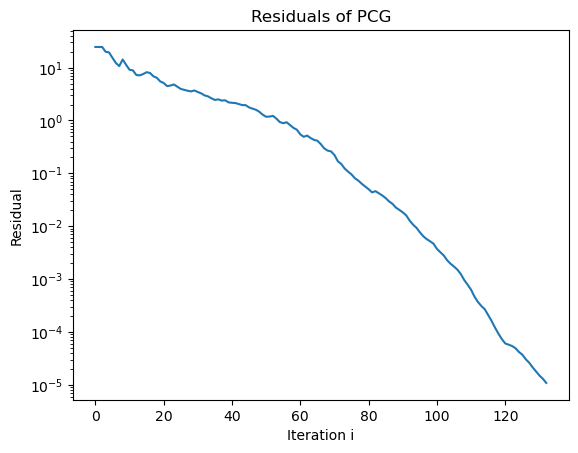

End residual: 1.0846336116070888e-05


In [6]:
from functions import *
h = 0.02
mux = 1
muy = 1
solgrad, res = diffusionGradSolver(mux, muy, h, 1e-6, 1000, None)
#plot_solution_3d(solgrad, h)
#plot_solution_2d(solgrad, h)
plot_residual(res)

(d) myPCG Implementation

In [33]:
import numpy as np
import scipy as sp
from scipy.sparse.linalg import norm
import matplotlib.pyplot as plt
import time


def myPCG( A, b, L, U, tol, maxit ):
    # A:       Matrix produced by diffusionMatrix
    # b:       RHS calculated by the source function
    # L and U: factors of the preconditioner from sp.spilu
    # tol:     tolerance for convergence
    # maxit:   maximum number of iterations

    # Initialize parameters
    start_time = time.time()
    M = (L @ U)
    #M = sp.sparse.linalg.inv(M)
    x = np.zeros_like(b)  # Initial guess
    r0 = b - (A@x)  # Initial residual
    z0 = sp.sparse.linalg.spsolve(M,r0)  # Apply preconditioner
    rz0 = r0.T @ z0
    d0 = z0.copy()
    i=0
    res=[]

    #PCG Loop
    while i < maxit:
        Ad0 = A @ d0
        alpha = (rz0) / (d0.T @ Ad0)
        x += alpha * d0
        r0 -= alpha * Ad0
        norm = np.linalg.norm(r0,2)
        res.append(norm)

        # Check for convergence
        if norm < tol:
            break

        z0 = sp.sparse.linalg.spsolve(M,r0)
        rz1 = r0.T @ z0
        beta = rz1 / rz0
        d0 = z0 + beta * d0
        rz0 = rz1
        i += 1
    end_time = time.time()
    print(f"myPCG::: Number of iterations = {i}, Norm = {norm}, Solution time = {end_time - start_time}")

    return x, res

In [34]:
import numpy as np
import scipy as sp
from scipy.sparse.linalg import norm
import matplotlib.pyplot as plt

def myPCGSolver(mux, muy, h, tol, maxit, drop_tol):
    n = int(1./h + 1)
    N = n**2
    intNodes, extNodes = boundaryConditions(n)
    res = []
    # Generate diffusion matrix
    A = diffusionMatrix(mux, muy, h)
    A_int = A[intNodes][:, intNodes]
    
    # Create ILU preconditioner using scipy
    M = sp.sparse.linalg.spilu(A_int, drop_tol=drop_tol)
    L = M.L
    U = M.U
    
    # Define source term and initialize vectors
    b = np.zeros(N, dtype=np.float64)
    for k in range (0,N):
        i, j = reverseIndexFD(k, n)
        b[k] = source_function( i*h, j*h )
    b_int = b[intNodes]

    sol = np.zeros_like(b)
    #A is a symmetric positive definite matrix. Symmetry needs to be preserved in the preconditioner. Therefore we can use M = L@L.T.
    #Consider calculating the inverse of U, L???
    sol[intNodes], res = myPCG(A_int,b_int,L,L.T,tol,maxit)
    return sol, res


CG::: Number of iterations: 133, Norm = 1.0846336116070888e-05, Solution time: 0.004889488220214844
myPCG::: Number of iterations = 244, Norm = 9.44790226458561e-07, Solution time = 1.5922653675079346


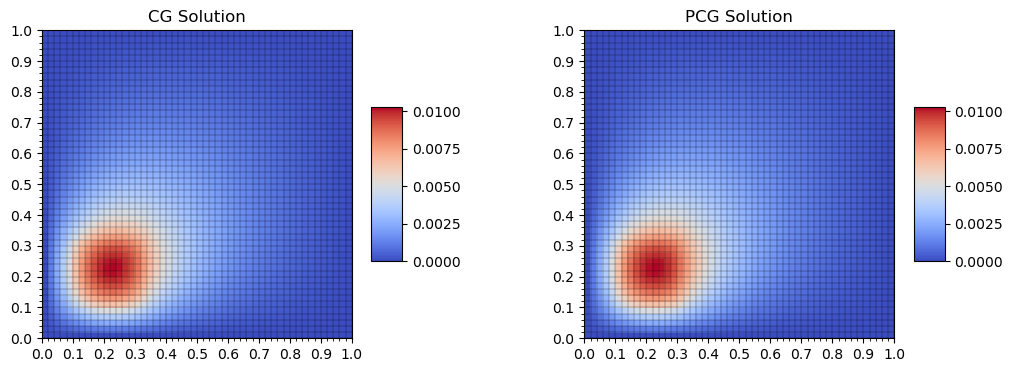

In [35]:
import time

h = 0.02
mux = 1.0
muy = 1.0
tol = 1e-6
maxit = 1000
drop_tol = 0.1

solcg, rescg = diffusionGradSolver(mux, muy, h, tol, maxit, None)
solpcg, respcg = myPCGSolver(mux,muy,h,tol,maxit,drop_tol)

plot_dualsolutions(solcg,solpcg,h)



Challenges with ILU preconditioned CG algorith:
- Convergence isn't reached with a drop off value of 0.1 for grid spacing less than ~0.05. Residual plateaus.
- We have not been given an h value - perhaps we are only supposed to use a large h value?
- If the drop off value is larger, then convergence is achieved.

(f) Compare the results for varying $\mu_x$

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.patches as patches
from functions import *

h = 0.02
mux = 1
mux0 = 0.1
mux1 = 0.01
muy = 1.0
tol = 1e-6
maxit = 1000
drop_tol = 0.1
drop_tol0 = 0.1
drop_tol1 = 0.1

solcg, rescg = diffusionGradSolver(mux, muy, h, tol, maxit, None)
solcg0, rescg0 = diffusionGradSolver(mux0, muy, h, tol, maxit, None)
solcg1, rescg1 = diffusionGradSolver(mux1, muy, h, tol, maxit, None)
solpcg, res = myPCGSolver(mux,muy,h,tol,maxit,drop_tol)
solpcg0, res0 = myPCGSolver(mux0,muy,h,tol,maxit,drop_tol0)
solpcg1, res1 = myPCGSolver(mux1,muy,h,tol,maxit,drop_tol1)

#compare_residuals(res, res0, res1,h)
compare_residuals(rescg, rescg0, rescg1, res, res0, res1,h)
plot_dualsolutions(solpcg0,solpcg1,h)


CG::: Number of iterations: 133, Norm = 1.0846336116070888e-05, Solution time: 0.007311344146728516
myPCG::: Number of iterations = 244, Norm = 9.44790226458561e-07, Solution time = 1.6268372535705566
myPCG::: Number of iterations = 437, Norm = 9.63116941404516e-07, Solution time = 2.173292636871338
myPCG::: Number of iterations = 932, Norm = 9.962810399016713e-07, Solution time = 3.798153877258301


TypeError: compare_residuals() takes 4 positional arguments but 5 were given

Compare custom CG solver to scipy implementation

In [ ]:
import numpy as np
import scipy as sp
import time
from scipy.sparse.linalg import norm
import matplotlib.pyplot as plt

def myCG( A, b, tol, maxit ):
    # A:       Matrix produced by diffusionMatrix
    # b:       RHS calculated by the source function
    # L and U: factors of the preconditioner from sp.spilu
    # tol:     tolerance for convergence
    # maxit:   maximum number of iterations

    # Initialize parameters
    start_time = time.time()
    x = np.zeros_like(b)  # Initial guess
    r0 = b - (A@x)  # Initial residual
    d0 = r0.copy()
    Ad0 = A @ d0
    i=0
    res=[]

    #PCG Loop
    while i < maxit:
        rTr = r0.T @ r0
        alpha = rTr / (d0.T @ Ad0)
        x += alpha * d0
        r0 -= alpha * Ad0
        norm = np.linalg.norm(r0,2)
        res.append(norm)
        # Check for convergence
        if norm < tol:
            break
        rTr1 = r0.T @ r0
        beta = rTr1 / (rTr)
        d0 = r0 + beta * d0
        Ad0 = A @ d0
        i += 1
    end_time = time.time()
    print(f"myCG::: Number of iterations = {i}, Norm = {norm}, Solution time = {end_time - start_time}")

    return x, res

In [ ]:
import inspect
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.sparse.linalg import norm

def mydiffusionGradSolver( mux, muy, h, tol, maxiter, M ):
  n = int(1./h + 1)  # dimension of spatial mesh in each dimension
  N = n**2
  f = sp.sparse.lil_matrix((N, 1), dtype=np.float64)

  F = np.zeros((N, 1), dtype=np.float64)
  intNodes, extNodes = boundaryConditions(n)
  
  # Placeholder for an initial guess
  u0 = np.zeros((N, 1))

  # Evaluate the source function
  for k in range (0,N):
    i, j = reverseIndexFD(k, n)
    F[k] = source_function( i*h, j*h )
  
  # Assemble the diffusion matrix
  A = diffusionMatrix(mux, muy, h)
  A_int = A[intNodes][:, intNodes]
  F_int = F[intNodes]
  u0_int = u0[intNodes]

  res = []

  f[intNodes], res = myCG(A_int, F_int, tol=tol, maxit=maxiter)
  f[extNodes] = u0[extNodes]

  return f.toarray(), res


CG::: Number of iterations: 26, Norm = 7.366977567367046e-07, Solution time: 0.002934694290161133
myCG::: Number of iterations = 25, Norm = 7.366977567501372e-07, Solution time = 0.0021491050720214844
myPCG::: Number of iterations = 33, Norm = 9.893437943417897e-07, Solution time = 0.007097005844116211


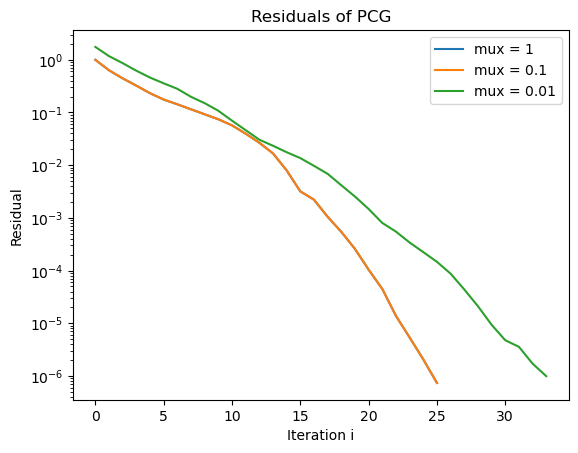

In [ ]:
h = 0.1
mux = 1.0
muy = 1.0
tol = 1e-6
maxit = 1000
solgrad, res = diffusionGradSolver(mux, muy, h, tol, maxit, None)
solgrad2, res2 = mydiffusionGradSolver(mux, muy, h, tol, maxit, None)
solpcg, res3 = myPCGSolver(mux,muy,h,1e-6,1000,0.1)

compare_residuals(res, res2, res3,h)


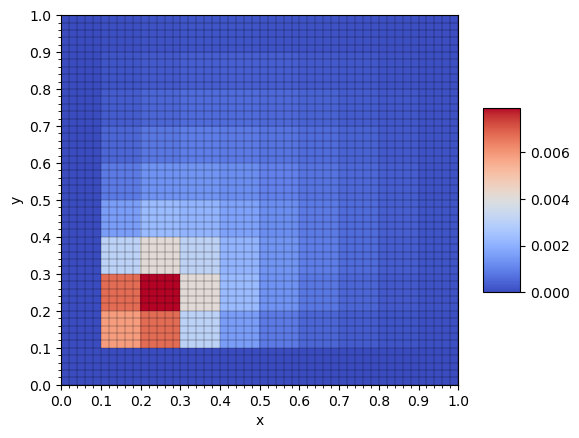

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.patches as patches

fig, ax = plt.subplots()

# Make data.
X = np.arange(0., 1.+h, h)
Y = np.arange(0., 1.+h, h)
X, Y = np.meshgrid(X, Y)
Z = solgrad.reshape(int(1./h+1),int(1./h+1))

# Plot the surface.
surf = ax.pcolor(X, Y, Z[:-1,:-1], shading='flat', cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
hx = 0.1
# Add a grid
plt.grid(which='major', axis='both', linestyle='-', color='k', linewidth=0.2)
plt.minorticks_on()
plt.grid(which='minor', axis='both', linestyle='-', color='k', linewidth=0.2)
major_ticks = np.arange(0., 1.+hx, hx)
minor_ticks = np.arange(0., 1.+hx, hx/5)
plt.xlabel('x')
plt.ylabel('y')

plt.xticks(major_ticks)
plt.yticks(major_ticks)
plt.show()

In [ ]:
import time

h = 0.02
mux = 0.01
muy = 1.0
tol = 1e-6
maxit = 1000
drop_tol = 0.1

start = time.time()
solcg = mydiffusionGradSolver(mux, muy, h, tol, maxit, None)
print(f'Time for CG: {time.time()-start}')

start = time.time()
solpcg, res = myPCGSolver(mux,muy,h,tol,maxit,drop_tol)
print(f'Time for PCG: {time.time()-start}')


myCG::: Number of iterations = 255, Norm = 8.643724345121089e-07, Solution time = 0.014231443405151367
Time for CG: 0.061765193939208984
myPCG::: Number of iterations = 932, Norm = 9.962810399016713e-07, Solution time = 3.786574602127075
Time for PCG: 3.827176570892334


In [ ]:

def is_spd(matrix):
    # Check if the matrix is square
    if matrix.shape[0] != matrix.shape[1]:
        return False

    # Check for symmetry
    if not np.allclose(matrix, matrix.T):
        return False

    # Check for positive definiteness
    try:
        np.linalg.cholesky(matrix)
        return True
    except np.linalg.LinAlgError:
        return False

#Check A
h = 0.02
mux=1.0
muy=1.0
drop_tol = 0.1
n = int(1./h + 1)
N = n**2

A = diffusionMatrix(mux, muy, h)
print(is_spd(A.todense()))
intNodes, extNodes = boundaryConditions(int(1./h+1))
A_int = A[intNodes][:, intNodes]
print(is_spd(A_int.todense()))



False
True
